# Set covering

In [15]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import math
import matplotlib.pyplot as plt

file_path = "weed_coordinates.txt"
data = pd.read_csv(file_path)
coordinates = pd.read_csv("xyz.csv",  index_col=0)

_z = []
for i in data.itertuples():
    cond = (coordinates['x'] == i.x) & (coordinates['y'] == i.y)
    item = coordinates.loc[cond, "z"]
    if len(item) == 0:
        v = 140
    else:
        v = float(item)
    _z.append(v)

data["z"] = _z

# 3d plot용
_points = [(row//10, col//10, hei//10) for row, col, hei in zip(data['x'], data['y'], data['z'])]
points = pd.DataFrame(_points, columns=['x', 'y', 'z'])

/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_1482/408296879.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  v = float(item)


In [5]:
# iteration = [5-1,6-1]
iteration = [1,1]

_row = [0,100,200,300,400,500]
_col = [0,100,200,300,400,500,600]

drone_angle = math.radians(120)
t = math.tan(drone_angle / 2)

## 상공 10m~50m
def calc_range(height):
    # 방사각 120도 일때 반지름 범위

    drone_height = [height -5, height]
    r = [h * math.tan(drone_angle / 2) for h in drone_height]

    return r[0], r[-1]

_, r0 = calc_range(20)
r1, r2 = calc_range(15)

def solve_sc(row_index, col_index):
    solution = {"x": [], "y": [], "z": []}
    inf = dict()
    
    con1 = (_row[row_index]<= data['y']) & (data['y']<=_row[row_index+1])
    con2 = (_col[col_index]<= data['x']) & (data['x']<=_col[col_index+1])
    df = data[con1 & con2]
    df['y'] = [_r - 100 * row_index for _r in df['y'].values]
    df['x'] = [_c - 100 * col_index for _c in df['x'].values]

    con1 = (_row[row_index]<= coordinates['y']) & (coordinates['y']<=_row[row_index+1])
    con2 = (_col[col_index]<= coordinates['x']) & (coordinates['x']<=_col[col_index+1])
    space = coordinates[con1 & con2]


    # 'row'와 'col' 열을 이용하여 튜플 리스트 생성
    required_pixels = [(x, y, z) for x, y, z in zip(df['x'], df['y'], df['z'])]

    # 데이터/파라미터 초기화
    N = 100  # 그리드의 가로 크기
    M = 100  # 그리드의 세로 크기
    J = range(N * M)  # 전체 그리드 픽셀 집합
    I = [y * N + x for (x, y, z) in required_pixels]
    Zj = [z for z in space['z']]
    Zi = [z for (x,y,z) in required_pixels]


    # 높이 고려 안했을 때의 최대 거리
    max_distance = r0

    # 제약 조건을 추가하기 전에, 각 i 픽셀에 대해 허용 가능한 j 픽셀만 필터링
    nearby_j = {i: [j for j in J if math.sqrt(((divmod(j, N)[0]-divmod(i, N)[0])**2 + 
                                            (divmod(j, N)[1]-divmod(i, N)[1])**2)) <= max_distance] for i in I}
            
    # 모델 생성
    model = gp.Model("pesticide_application")

    # 변수 생성
    S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
    C = model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
    a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")
    q = model.addVars(J, vtype=GRB.CONTINUOUS, name="q")

    # 목적 함수 설정: 최소한의 살포 지점 선택
    model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

    # 제약 조건 추가
    index = 0
    for i in I:
        xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
        zi = Zi[index]
        index += 1
        for j in nearby_j[i]:
            
            xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
            dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2))  # 두 좌표간의 거리

            # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건                      
            model.addConstr(dist * C[i,j]<=a[j])
            model.addConstr(a[j]<= r2)
            model.addConstr(S[j] >= C[i, j])

    # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
    for i in I:
        model.addConstr(gp.quicksum(C[i, j] for j in nearby_j[i]) >= 1)

    # 모델 최적화
    model.optimize()

    """여기부터 주석"""
    
    # 두 번째 모델 생성
    second_model = gp.Model("second_model")

    # 첫 번째 모델의 변수와 제약 조건을 복사
    S2 = second_model.addVars(J, vtype=GRB.BINARY, name="S")
    C2 = second_model.addVars([(i, j) for i in I for j in nearby_j[i]], vtype=GRB.BINARY, name="C")
    a2 = second_model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

    # 첫 번째 모델의 솔루션 고정
    if model.status == GRB.OPTIMAL:
        for j in J:
            S[j].start = S[j].x
            a[j].start = a[j].x
        for i, j in C.keys():
            C[i, j].start = C[i, j].x

        # 첫 번째 모델의 솔루션을 두 번째 모델에 고정
        for j in J:
            S2[j].lb = S[j].x
            S2[j].ub = S[j].x

        for i, j in C.keys():
            C2[i, j].lb = C[i, j].x
            C2[i, j].ub = C[i, j].x
    else:
        inf["row_index"] = row_index
        inf['col_index'] = col_index

    # 두 번째 모델의 목적 함수 설정
    second_model.setObjective(gp.quicksum(a2[j] for j in J), sense=GRB.MINIMIZE)

    # 제약 조건 추가
    index = 0
    for i in I:
        xi, yi = divmod(i, N)
        zi = Zi[index]
        index += 1
        for j in nearby_j[i]:
            xj, yj = divmod(j, N)

            zj = Zj[j]
            dist = math.sqrt((xj - xi)**2 + (yj - yi)**2)
            second_model.addConstr(r1 <= a2[j])
            second_model.addConstr(dist * C2[i, j] <= a2[j])
            second_model.addConstr(a2[j] <= r2)

    # 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
    for i in I:
        second_model.addConstr(gp.quicksum(C2[i, j] for j in nearby_j[i]) >= 1)

    # 두 번째 모델 최적화
    second_model.optimize()

    # 최적해 출력 및 시각화 준비
    if second_model.status == GRB.OPTIMAL:
        # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

        # 시각화 코드
        fig, ax = plt.subplots(figsize=(12, 10))

        # 농약 살포가 필요한 픽셀
        for i in I:
            xi, yi = divmod(i, N)
            ax.scatter(xi, yi, color='red', marker='s', s=10)

        # 선택된 살포 지점 및 커버 범위
        for j in J:
            if S[j].x > 0.5:
                xj, yj = divmod(j, N)
                aj = a2[j].x
                rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
                ax.add_artist(rect)
                ax.scatter(xj, yj, color='blue', marker='o', s=10)

                solution['x'].append(xj + row_index * 100)
                solution['y'].append(yj + col_index * 100)
                solution['z'].append(aj)

        C = {var.varName: var.X for var in second_model.getVars() if (var.varName[0] == "C") & (var.X != 0)}

        plt.xlim(-1, N)
        plt.ylim(-1, M)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        plt.title('Pesticide Application Optimization with Varying Z Range')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.savefig(f"sc{row_index}_{col_index}")
    else:
        inf["row_index"] = row_index
        inf['col_index'] = col_index
        print("No optimal solution found.")

    """여기까지 주석"""

    return solution, inf, C

In [6]:
iteration = [5,6]
# iteration = [1,1]
_row = [0,100,200,300,400,500]
_col = [0,100,200,300,400,500,600]

solutions = []
infeasible = []
cluster = []

for row_index in range(iteration[0]):
    for col_index in range(iteration[1]):
        sol, inf, c = solve_sc(row_index, col_index)
        solutions.append(sol)
        infeasible.append(inf)
        cluster.append(c)

/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_1482/2696457451.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = [_r - 100 * row_index for _r in df['y'].values]
/var/folders/dj/c81zc2b12d54dz30fc1stjv80000gn/T/ipykernel_1482/2696457451.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = [_c - 100 * col_index for _c in df['x'].values]


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.4.0 23E214)

CPU model: Intel(R) Core(TM) i5-8500B CPU @ 3.00GHz
Thread count: 6 physical cores, 6 logical processors, using up to 6 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [7]:
# j에 속하는 i들을 분류하는 함수
def classify_by_j(data):
    result = {}
    for key in data.keys():
        i, j = map(int, key[2:-1].split(','))
        if j not in result:
            result[j] = []
        result[j].append(i)
    return result

# 정규 표현식을 사용하여 문자열에서 숫자 추출
cluster_list = []
for c in cluster:
    cluster_list.append(classify_by_j(c))

N = 100
M = 100
# 시각화 코드
colors = [
    '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD',
    '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF'
]
c_index = 0
p_index = 0
for c in cluster_list:
    fig, ax = plt.subplots(figsize=(12, 10))

    for j, I in c.items():
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color=colors[c_index % 10], marker='s', s=20)

        for i in I:
            xi, yi = divmod(i, N)
            ax.scatter(xi, yi, color=colors[c_index % 10], marker='o', s=10)

        c_index += 1

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.savefig(f"cluster{p_index}")
    plt.close()

    p_index += 1

In [5]:
scSol = pd.DataFrame({"x": [0], "y": [0], "z":[0]})
for sol in solutions:
    scSol = pd.concat([scSol, pd.DataFrame(sol)], axis=0, ignore_index=True)

scSol['z'] = [z/t for z in scSol['z']]

newz = []
for row in scSol.itertuples():
    con1 = (coordinates['x'] == row.y)
    con2 = (coordinates['y'] == row.x)

    p = coordinates.loc[con1 & con2, 'z'].values 
    newz.append(float(row.z + p /10))
scSol['z'] = newz

scSol.to_csv("sc_solutions.csv")

/var/folders/52/b3jtlwjs7f9bkf0l6zqydnsc0000gn/T/ipykernel_1624/2916735542.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  newz.append(float(row.z + p /10))


# Routing

In [6]:
def calculate_distances(df):
    # 노드의 수를 구합니다.
    num_nodes = len(df)
    
    # 거리를 저장할 데이터프레임을 생성합니다.
    distances = pd.DataFrame(np.zeros((num_nodes, num_nodes)), columns=df.index, index=df.index)
    
    # 모든 노드 쌍에 대해 거리를 계산합니다.
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # 두 노드 간의 유클리드 거리를 계산합니다.
            distance = np.sqrt((df.iloc[i]['x'] - df.iloc[j]['x'])**2 + 
                               (df.iloc[i]['y'] - df.iloc[j]['y'])**2 + 
                               (df.iloc[i]['z'] - df.iloc[j]['z'])**2)
            distances.iloc[i, j] = distance
            distances.iloc[j, i] = distance
    
    return distances

# 데이터프레임
file_name = "sc_solutions.csv"
nodes = pd.read_csv(file_name, sep=',', index_col=0)

# 각 노드 간의 거리 계산
distances = calculate_distances(nodes)
distances.to_csv("dist.csv")

selected = nodes[["x", "y"]]
selected.to_csv("selected.csv")


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pandas as pd

max_distance = 1600  # 5km

def create_data_model(distances, coordinates):
    data = {}
    
    """데이터 모델을 생성합니다."""
    dist_matrix = distances.values.tolist()
    data['distance_matrix'] = dist_matrix

    coord_matrix = coordinates.values.tolist()
    data['locations'] = coord_matrix

    data['num_vehicles'] = 15
    data['depot'] = 0

    return data

def solve():
    """VRP 문제를 설정하고 해결합니다."""
    coord = pd.read_csv("selected.csv", sep=',', index_col=0)
    dist =pd.read_csv("dist.csv", index_col=0)
    data = create_data_model(dist, coord)

    # 노드 수, 차량 수, 출발/도착 지점을 설정
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # 경로 모델 생성
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """두 노드 간의 거리를 계산하는 콜백 함수"""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    # 거리 콜백 함수 등록
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # 비용 함수 설정
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # 거리 차원 생성
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_distance,  # 각 차량의 최대 이동 거리
        True,  # start cumul to zero
        dimension_name)
    
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(0)

    # 탐색 매개변수 설정
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 다양한 첫 번째 솔루션 전략 시도
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    # search_parameters.time_limit.seconds = 300
    search_parameters.solution_limit = 1000
    # 로그 출력을 비활성화
    search_parameters.log_search = True

    # 문제 해결
    solution = routing.SolveWithParameters(search_parameters)

    return manager, routing, solution, distance_dimension, data

def print_solution(manager, routing, solution, distance_dimension, data):
    """해결책을 출력하고 시각화합니다."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    total_distance = 0
    routes = []
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route = []
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            plan_output += ' {} ->'.format(node_index)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        plan_output += ' {}\n'.format(node_index)
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        routes.append(route)
        total_distance += route_distance
    print('Total distance of all routes: {}km'.format(total_distance))

    return routes

def plot_routes(locations, routes):
    import matplotlib.pyplot as plt
    """경로를 시각화합니다."""
    plt.figure(figsize=(12, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    for route, color in zip(routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            plt.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                        angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            plt.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Vehicle Routes')
    plt.grid()
    plt.show()

def plot_individual_routes(locations, routes):
    _routes = routes
        
    """경로를 시각화합니다."""
    num_routes = len(_routes)
    fig, axes = plt.subplots(1, num_routes, figsize=(20, 5))
    colors = cm.rainbow(np.linspace(0, 1, num_routes))

    for ax, route, color in zip(axes, _routes, colors):
        x_coords = [locations[node][0] for node in route]
        y_coords = [locations[node][1] for node in route]
        for i in range(len(route) - 1):
            ax.quiver(x_coords[i], y_coords[i], x_coords[i + 1] - x_coords[i], y_coords[i + 1] - y_coords[i],
                        angles='xy', scale_units='xy', scale=1, color=color, width=0.003)
        for i, node in enumerate(route):
            ax.text(locations[node][0], locations[node][1], str(node), fontsize=12, ha='right')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.set_title(f'Vehicle {_routes.index(route)}')
        ax.grid()

    plt.suptitle('Vehicle Routes')
    plt.show()

    return _routes


I0000 00:00:1717761732.302449   24929 search.cc:285] Start search (memory used = 935.12 MB)
I0000 00:00:1717761732.303296   24929 search.cc:285] Root node processed (time = 0 ms, constraints = 405, memory used = 935.24 MB)
I0000 00:00:1717761732.310974   24929 search.cc:285] Solution #0 (9220, time = 7 ms, branches = 34, failures = 1, depth = 33, memory used = 935.68 MB, limit = 0%)
I0000 00:00:1717761732.312940   24929 search.cc:285] Solution #1 (9148, maximum = 9220, time = 9 ms, branches = 38, failures = 3, depth = 33, Relocate<1>, neighbors = 66, filtered neighbors = 1, accepted neighbors = 1, memory used = 935.75 MB, limit = 0%)
I0000 00:00:1717761732.313681   24929 search.cc:285] Solution #2 (9106, maximum = 9220, time = 10 ms, branches = 43, failures = 5, depth = 33, Relocate<1>, neighbors = 67, filtered neighbors = 2, accepted neighbors = 2, memory used = 935.77 MB, limit = 0%)
I0000 00:00:1717761732.315954   24929 search.cc:285] Solution #3 (9103, maximum = 9220, time = 12 ms,

Objective: 5651
Route for vehicle 0:
 0 -> 24 -> 25 -> 47 -> 46 -> 48 -> 38 -> 36 -> 26 -> 15 -> 0
Distance of the route: 1395km

Route for vehicle 1:
 0 -> 3 -> 4 -> 17 -> 19 -> 20 -> 30 -> 32 -> 31 -> 21 -> 10 -> 7 -> 8 -> 9 -> 6 -> 5 -> 0
Distance of the route: 1539km

Route for vehicle 2:
 0 -> 0
Distance of the route: 0km

Route for vehicle 3:
 0 -> 2 -> 16 -> 18 -> 27 -> 29 -> 39 -> 40 -> 42 -> 43 -> 49 -> 50 -> 41 -> 37 -> 28 -> 14 -> 13 -> 0
Distance of the route: 1600km

Route for vehicle 4:
 0 -> 1 -> 12 -> 35 -> 34 -> 45 -> 44 -> 33 -> 23 -> 22 -> 11 -> 0
Distance of the route: 1117km

Route for vehicle 5:
 0 -> 0
Distance of the route: 0km

Route for vehicle 6:
 0 -> 0
Distance of the route: 0km

Route for vehicle 7:
 0 -> 0
Distance of the route: 0km

Route for vehicle 8:
 0 -> 0
Distance of the route: 0km

Route for vehicle 9:
 0 -> 0
Distance of the route: 0km

Route for vehicle 10:
 0 -> 0
Distance of the route: 0km

Route for vehicle 11:
 0 -> 0
Distance of the route: 

I0000 00:00:1717761762.250407   24929 search.cc:285] Solution #998 (5657, minimum = 5651, maximum = 9220, time = 29947 ms, branches = 5783, failures = 2570, depth = 33, Relocate<1>, neighbors = 2422605, filtered neighbors = 998, accepted neighbors = 998, memory used = 936.79 MB, limit = 99%)
I0000 00:00:1717761762.252924   24929 search.cc:285] Solution #999 (5658, minimum = 5651, maximum = 9220, time = 29949 ms, branches = 5788, failures = 2572, depth = 33, Relocate<1>, neighbors = 2422777, filtered neighbors = 999, accepted neighbors = 999, memory used = 936.79 MB, limit = 100%)
I0000 00:00:1717761762.253060   24929 search.cc:285] Finished search tree (time = 29949 ms, branches = 5788, failures = 2601, neighbors = 2422777, filtered neighbors = 999, accepted neigbors = 999, memory used = 936.79 MB)
I0000 00:00:1717761762.253134   24929 search.cc:285] End search (time = 29950 ms, branches = 5788, failures = 2601, memory used = 936.79 MB, speed = 193 branches/s)


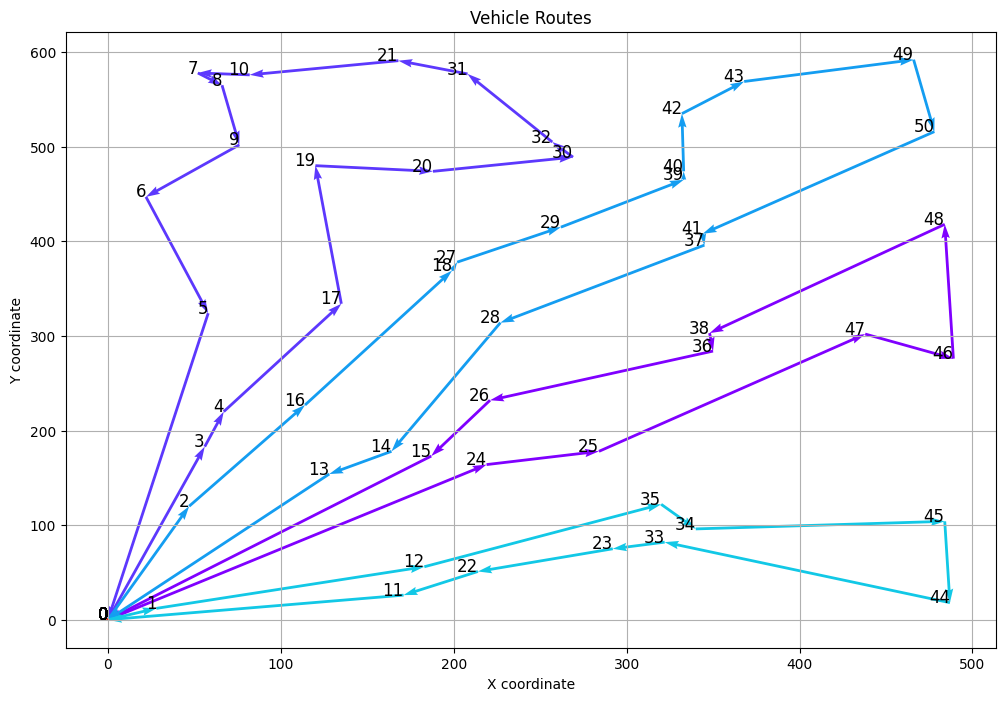

In [12]:
manager, routing, solution, distance_dimension, dm = solve()

if solution:
    routes = print_solution(manager, routing, solution, distance_dimension, dm)
else:
    print("No solution found!")

# 경로 시각화
plot_routes(dm['locations'], routes)

# 여기는 수정 중이라 무시

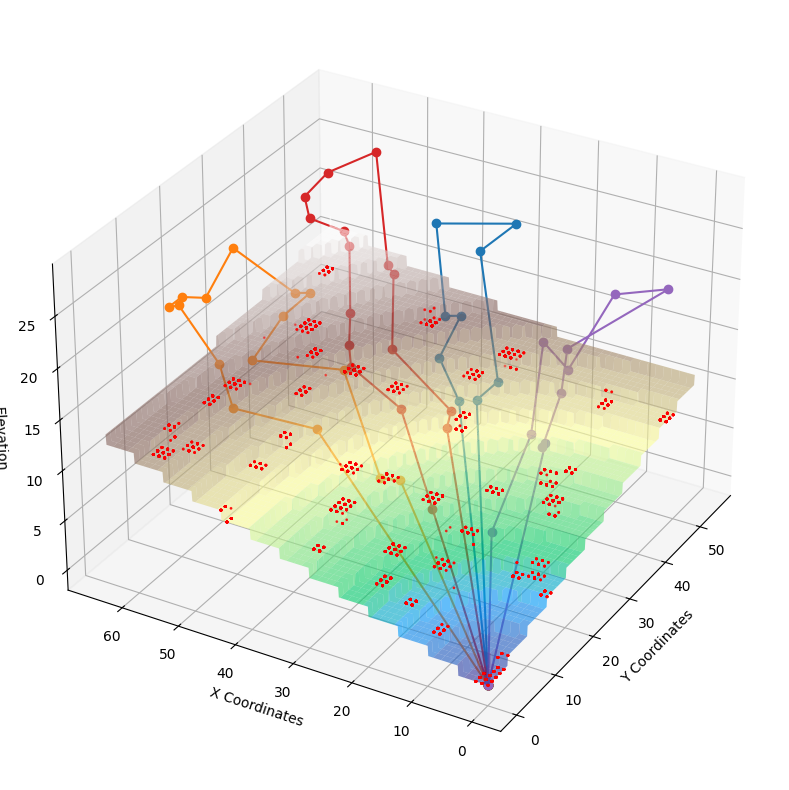

In [16]:
import noise

# 3d plot용
_points = [(row//10, col//10, hei//10) for row, col, hei in zip(data['x'], data['y'], data['z'])]
points = pd.DataFrame(_points, columns=['x', 'y', 'z'])

# 데이터프레임
file_name = "sc_solutions.csv"
nodes = pd.read_csv(file_name, sep=',', index_col=0)

N = 650//10
M  = 550//10

def terraced_field_with_noise(x, y, N ,M ,scale=0.1, height_scale=5, noise_scale=1.5):
    # 노이즈를 생성하여 지형에 적용합니다.
    base_noise = noise.pnoise2(scale * N, scale * M) * noise_scale
    # 계단식 농지의 높이를 계산합니다.
    height_filter = 1
    terrace_height = np.floor((np.sqrt(x**2 + y**2) + base_noise) / height_scale) * height_filter
    return terrace_height

# 그리드 생성
x = np.linspace(0, N, N*10)
y = np.linspace(0, M, M*10)
x, y = np.meshgrid(x, y)
z = terraced_field_with_noise(x, y, 400, 400)

# 플롯 설정
fig = plt.figure(figsize=(15, 10))  # 여기서 그래프의 크기를 12x8 인치로 설정합니다.
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y, x, z, cmap='terrain', edgecolor='none', alpha = 0.6)

# 축 레이블 설정
ax.set_xlabel('Y Coordinates')
ax.set_ylabel('X Coordinates')
ax.set_zlabel('Elevation')

# 그래프를 45도 회전
ax.view_init(elev=30, azim=-150)  # elev는 30도로 설정, azim은 45도로 설정

# 점 찍기
ax.scatter(points["y"],points["x"] , points["z"], color='r', s=1)  # s는 점의 크기

for route in routes:
    rx = []
    ry = []
    rz = []
    for node in route:
        loc = nodes.iloc[node]
        rx.append(loc['x']//10)
        ry.append(loc['y']//10)
        rz.append(loc['z'])
    ax.plot(rx,ry,rz,marker='o')

# 표시
plt.show()



In [ ]:
N = 650//10
M  = 550//10

# 그리드 생성
x = np.linspace(0, N, N*10)
y = np.linspace(0, M, M*10)
x, y = np.meshgrid(x, y)
z = terraced_field_with_noise(x, y, 400, 400)

# 플롯 설정
fig = plt.figure(figsize=(15, 10))  # 여기서 그래프의 크기를 12x8 인치로 설정합니다.
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none', alpha = 0.8)

# 축 레이블 설정
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_zlabel('Elevation')

# 그래프를 45도 회전
ax.view_init(elev=30, azim=-150)  # elev는 30도로 설정, azim은 45도로 설정

# 점 찍기
ax.scatter(points["x"], points["y"], points["z"], color='r', s=1)  # s는 점의 크기

# for route in routes:
#     rx = []
#     ry = []
#     rz = []
#     for node in route:
#         loc = nodes.iloc[node]
#         rx.append(loc['x'])
#         ry.append(loc['y'])
#         rz.append(loc['z'])
#     ax.plot(rx,ry,rz,marker='o')

# 표시
plt.show()



In [24]:
nodes = pd.read_csv("sc_solutions.csv",index_col=0)
selected = pd.read_csv("weed_coordinates.txt")

In [25]:
coverd = []
for node in nodes.itertuples():
    cover = 
    node.x

,x,y,z
0,0,0,0.000000
1,28,12,13.964240
2,47,120,13.547005
3,56,183,14.888370
4,67,220,14.000000
5,58,324,17.387127
6,22,447,18.408330
7,52,578,24.976170
8,66,565,24.976170
9,76,502,20.000000
